# CreditCardApproval MachineLearning Diana Max

In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    FunctionTransformer,
    TargetEncoder,
    label_binarize,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    make_scorer,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    DetCurveDisplay,
)

from sklearn.model_selection import (
    cross_validate,
    cross_val_score,
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    train_test_split,
    StratifiedKFold,
    cross_validate,
    RepeatedStratifiedKFold,
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import clone
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.ensemble import AdaBoostClassifier

credit_approval = fetch_ucirepo(id=27)

X = credit_approval.data.features
y = credit_approval.data.targets
df = credit_approval.data.original

# preprocessing

In [2]:
"""
Maybe add some more advanced techniques from here later: https://scikit-learn.org/stable/modules/preprocessing.html

"""

'\nMaybe add some more advanced techniques from here later: https://scikit-learn.org/stable/modules/preprocessing.html\n\n'

### feature engineering: mixed numerical categorical feature space (this is old code, use fully numerical feature space for now)

In [3]:
make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"), OneHotEncoder(drop="first")
        ),
        ["A1"],
    ),
    (make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler()), ["A2"]),
    (
        make_pipeline(
            FunctionTransformer(lambda col: col.mask(col != "u", "non-u")),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(drop="first"),
        ),
        ["A4"],
    ),
    (
        make_pipeline(
            FunctionTransformer(
                lambda col: col.replace(
                    {
                        "v": "v",
                        "h": "h",
                        "bb": "other",
                        "ff": "other",
                        "j": "other",
                        "z": "other",
                        "dd": "other",
                        "n": "other",
                        "o": "other",
                    }
                )
            ),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(drop="first"),
        ),
        ["A7"],
    ),
    (
        make_pipeline(
            FunctionTransformer(
                lambda col: col.replace({"g": "g", "s": "non-g", "p": "non-g"})
            ),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(drop="first"),
        ),
        ["A13"],
    ),
    (
        "test",
        make_pipeline(
            FunctionTransformer(np.log1p),
            SimpleImputer(strategy="median"),
            MinMaxScaler(),
        ),
        ["A11", "A14", "A15"],
    ),
    # continuous default
    (
        make_pipeline(
            MinMaxScaler(),
        ),
        ["A3", "A8"],
    ),
    # categorical default
    (
        make_pipeline(
            OneHotEncoder(drop="first"),
        ),
        ["A9", "A10", "A12"],
    ),
    # remove: A5, A6
    remainder="drop",
)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['A1']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['A2']),
                                ('pipeline-3',
                                 Pipeline(steps=[('functiontransformer...
                                ('test', 'test',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())])),
                                ('pipeline-6',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['A3', 'A8']),
                                ('pipeline-7',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['A9', 'A10', 'A12'])])

### feature engineering: fully numerical feature space

#### variant 1: include A7

In [4]:
column_tweaker_include_a7 = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(sparse_output=False, drop="first"),
        ),
        ["A1", "A9", "A10", "A12"],
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            FunctionTransformer(lambda col: label_binarize(col, classes=["u"])),
        ),
        ["A4"],
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            FunctionTransformer(lambda col: label_binarize(col, classes=["g"])),
        ),
        ["A5"],
    ),
    (make_pipeline(TargetEncoder(), SimpleImputer(strategy="median")), ["A6", "A7"]),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            FunctionTransformer(lambda col: label_binarize(col, classes=["g"])),
        ),
        ["A13"],
    ),
    (
        make_pipeline(FunctionTransformer(np.log1p), SimpleImputer(strategy="median")),
        ["A2", "A3", "A8", "A11", "A14", "A15"],
    ),
    # leave everything else untouched
    remainder="drop",
)

#### variant 2: exclude A7

In [5]:
column_tweaker_exclude_a7 = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(sparse_output=False, drop="first"),
        ),
        ["A1", "A9", "A10", "A12"],
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            FunctionTransformer(lambda col: label_binarize(col, classes=["u"])),
        ),
        ["A4"],
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            FunctionTransformer(lambda col: label_binarize(col, classes=["g"])),
        ),
        ["A5"],
    ),
    (make_pipeline(TargetEncoder(), SimpleImputer(strategy="median")), ["A6"]),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            FunctionTransformer(lambda col: label_binarize(col, classes=["g"])),
        ),
        ["A13"],
    ),
    (
        make_pipeline(FunctionTransformer(np.log1p), SimpleImputer(strategy="median")),
        ["A2", "A3", "A8", "A11", "A14", "A15"],
    ),
    # leave everything else untouched
    remainder="drop",
)

### feature scaling

In [6]:
column_scaler = MinMaxScaler()

### PCA

In [7]:
column_pca = PCA(n_components=0.99, svd_solver="full")

### put together pipelines

#### feature engineering pipeline 1

In [8]:
preprocessing_pipe = make_pipeline(column_tweaker_exclude_a7, column_scaler, column_pca)
preprocessing_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['A1', 'A9', 'A10', 'A12']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontr...
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function <lambda> at 0x73409b0bad40>))]),
                                                  ['A13']),
                                                 ('pipeline-6',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['A2', 'A3', 'A8', 'A11',
                                                   'A14', 'A15'])])),
                ('minmaxscaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.99, svd_solver='full'))])

#### feature engineering pipeline 2

In [9]:
"""

In which different formats do we need the data for different classifiers ?

"""

'\n\nIn which different formats do we need the data for different classifiers ?\n\n'

# train test validation split

In [10]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

In [11]:
y = y.values.ravel()
y[y == "+"] = 1
y[y == "-"] = 0
y = y.astype(np.int8)

In [12]:
X_preprocessed = preprocessing_pipe.fit_transform(X=X, y=y)

In [13]:
X_train, X_test_validate, y_train, y_test_validate = train_test_split(
    X_preprocessed, y, test_size=0.1, random_state=seed
)
X_train.shape, y_train.shape

((621, 12), (621,))

In [14]:
X_test, X_validate, y_test, y_validate = train_test_split(
    X_test_validate, y_test_validate, test_size=0.5
)
(X_test.shape, y_test.shape), (X_validate.shape, y_validate.shape)

(((34, 12), (34,)), ((35, 12), (35,)))

In [15]:
X_train_test, y_train_test = np.concatenate((X_train, X_test)), np.concatenate(
    (y_train, y_test)
)

# train & optimise different models

On what to optimize ?

The task is o predict, if, given the different parameters, access to a credit card is denied or granted.

- The worst case would be to give access to a position that is obvious fraud (False Positive). Cost: The owner looses money.
- Rejecting access to a legit position (False Negative) would be inconvenient, since someone wouldn't be able to draw his money, but we consider it less of a problem than a False Positive.

- Obviously, a True Positive would be giving someone his money while a True Negative would be denying fraud.



In summary, we primarily optimize for the False Positive rate.

Additional metrics:
- The dataset is balanced therefore classificatino accuracy is a meaningfull metrix as well.

In [16]:
scoring = {
    "Precision": make_scorer(precision_score, pos_label=1),
    "Accuracy": make_scorer(accuracy_score),
}

How to compare classifiers ?
- Plot learning curves.
- Compare missclassified examples.
- Compare robustness in different CV-splits.

Next, we compare the performance of a variety of common ML classifiers. Since we are relativey naive to which classifiers could work, we try a diverse set.

##### Plotting function

In [17]:
def plot_cv_scores(base, grid):
    # Precision
    # Baseline
    mean = base["test_Precision"].mean()
    std = base["test_Precision"].std()
    plt.axhline(
        y=0,
        color="grey",
        linestyle="-",
        linewidth=0.5,
    )
    plt.plot(mean, 0, "o", color="black", markersize=10, label=f"Mean = {mean:.2f}")
    plt.plot(
        [mean - std, mean + std],
        [0, 0],
        color="black",
        linewidth=1.5,
        label=f"STD = {std:.2f}",
    )
    plt.vlines(
        [mean - std, mean + std], ymin=-0.1, ymax=0.1, color="black", linewidth=1.5
    )

    # GridSearch
    mean = grid["test_Precision"].mean()
    std = grid["test_Precision"].std()
    plt.axhline(
        y=0,
        color="grey",
        linestyle="-",
        linewidth=0.5,
    )
    plt.plot(mean, 0, "o", color="magenta", markersize=10, label=f"Mean = {mean:.2f}")
    plt.plot(
        [mean - std, mean + std],
        [0, 0],
        color="magenta",
        linewidth=1.5,
        label=f"STD = {std:.2f}",
    )
    plt.vlines(
        [mean - std, mean + std], ymin=-0.1, ymax=0.1, color="magenta", linewidth=1.5
    )

    # Accuracy
    # Baseline
    mean = base["test_Accuracy"].mean()
    std = base["test_Accuracy"].std()
    plt.axhline(
        y=1,
        color="grey",
        linestyle="-",
        linewidth=0.5,
    )
    plt.plot(mean, 1, "o", color="black", markersize=10, label=f"Mean = {mean:.2f}")
    plt.plot(
        [mean - std, mean + std],
        [1, 1],
        color="black",
        linewidth=1.5,
        label=f"STD = {std:.2f}",
    )
    plt.vlines(
        [mean - std, mean + std],
        ymin=1 - 0.1,
        ymax=1 + 0.1,
        color="black",
        linewidth=1.5,
    )

    # GridSearch
    mean = grid["test_Accuracy"].mean()
    std = grid["test_Accuracy"].std()
    plt.axhline(
        y=1,
        color="grey",
        linestyle="-",
        linewidth=0.5,
    )
    plt.plot(mean, 1, "o", color="magenta", markersize=10, label=f"Mean = {mean:.2f}")
    plt.plot(
        [mean - std, mean + std],
        [1, 1],
        color="magenta",
        linewidth=1.5,
        label=f"STD = {std:.2f}",
    )
    plt.vlines(
        [mean - std, mean + std],
        ymin=1 - 0.1,
        ymax=1 + 0.1,
        color="magenta",
        linewidth=1.5,
    )

    plt.ylabel("")
    plt.ylim(-0.8, 1.8)
    plt.yticks(ticks=[0, 1], labels=["Precision", "Accuracy"])

    plt.xlim(0.70, 0.95)
    plt.xlabel("")
    plt.suptitle("Mean and std of 10-fold CV")
    plt.title("baseline (black) vs estimator from GridSearch (magenta))")

## Linear Discriminant Analysis

Parameters:
'priors' : The default value estimates the class proportions from the training set. Since our dataset with n<1000 is relatively small, class proportions might be slightly skewed leading to a suboptimal estimation from the training data .

### Baseline

In [18]:
lda_base_cv = cross_validate(
    LinearDiscriminantAnalysis(), X_train_test, y_train_test, cv=10, scoring=scoring
)

### GridSeach

In [19]:
param_grid = {
    "priors": [
        [0.05, 0.95],
        [0.1, 0.9],
        [0.15, 0.85],
        [0.2, 0.8],
        [0.25, 0.75],
        [0.3, 0.7],
        [0.35, 0.65],
        [0.4, 0.6],
        [0.45, 0.55],
        [0.5, 0.5],
        [0.55, 0.45],
        [0.6, 0.4],
        [0.65, 0.35],
        [0.7, 0.3],
        [0.75, 0.25],
        [0.8, 0.2],
        [0.85, 0.15],
        [0.9, 0.1],
        [0.95, 0.05],
    ]
}
lda_grid = GridSearchCV(
    estimator=LinearDiscriminantAnalysis(),
    param_grid=param_grid,
    cv=10,
    scoring=scoring,
    refit="Accuracy",
)
lda_grid.fit(X_train_test, y_train_test)
lda_grid.best_estimator_

LinearDiscriminantAnalysis(priors=[0.8, 0.2])

In [20]:
lda_grid_cv = cross_validate(
    lda_grid.best_estimator_, X_train_test, y_train_test, cv=10, scoring=scoring
)

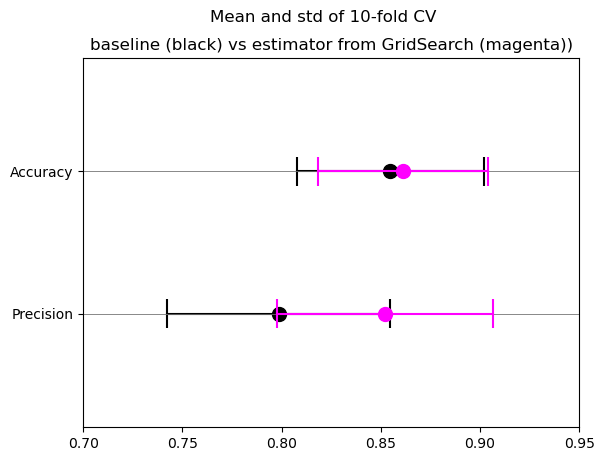

In [21]:
plot_cv_scores(lda_base_cv, lda_grid_cv)

## Quadratic Discriminant Analysis

### Baseline

In [22]:
qda_base_cv = cross_validate(
    QuadraticDiscriminantAnalysis(), X_train_test, y_train_test, cv=10, scoring=scoring
)

### GridSearch

In [23]:
param_grid = {
    "priors": [
        [0.05, 0.95],
        [0.1, 0.9],
        [0.15, 0.85],
        [0.2, 0.8],
        [0.25, 0.75],
        [0.3, 0.7],
        [0.35, 0.65],
        [0.4, 0.6],
        [0.45, 0.55],
        [0.5, 0.5],
        [0.55, 0.45],
        [0.6, 0.4],
        [0.65, 0.35],
        [0.7, 0.3],
        [0.75, 0.25],
        [0.8, 0.2],
        [0.85, 0.15],
        [0.9, 0.1],
        [0.95, 0.05],
    ]
}

qda_grid = GridSearchCV(
    estimator=QuadraticDiscriminantAnalysis(),
    param_grid=param_grid,
    cv=10,
    scoring=scoring,
    refit="Accuracy",
)
qda_grid.fit(X_train_test, y_train_test)
qda_grid.best_params_

{'priors': [0.75, 0.25]}

In [24]:
qda_grid_cv = cross_validate(
    qda_grid.best_estimator_, X_train_test, y_train_test, cv=10, scoring=scoring
)

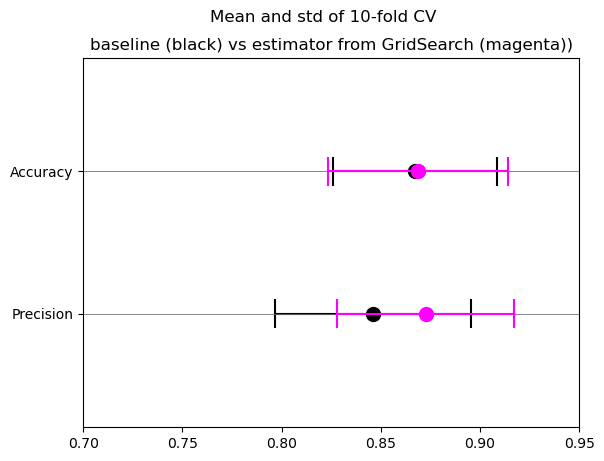

In [25]:
plot_cv_scores(qda_base_cv, qda_grid_cv)

## Random Forest

#### Baseline

In [26]:
rf_base_cv = cross_validate(
    RandomForestClassifier(), X_train_test, y_train_test, cv=10, scoring=scoring
)

#### GridSearchCV

In [28]:
# best values, so we don't need to run excessive GridSearch again
param_grid = {
    "n_estimators": [300],
    "max_depth": [None],
    "min_samples_split": [10],
    "min_samples_leaf": [4],
    "max_features": ["sqrt"],
    "bootstrap": [True],
    "criterion": ["entropy"],
}

# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10, 15, 20],
#     'min_samples_leaf': [1, 2, 4, 6, 8, 10],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy']
# }

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    scoring=scoring,
    param_grid=param_grid,
    verbose=1,
    cv=10,
    refit="Accuracy",
    n_jobs=-1,
)

rf_grid.fit(X_train_test, y_train_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['entropy'],
                         'max_depth': [None], 'max_features': ['sqrt'],
                         'min_samples_leaf': [4], 'min_samples_split': [10],
                         'n_estimators': [300]},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'Precision': make_scorer(precision_score, response_method='predict', pos_label=1)},
             verbose=1)

In [37]:
rf_grid_cv = cross_validate(
    rf_grid.best_estimator_, X_train_test, y_train_test, cv=10, scoring=scoring
)

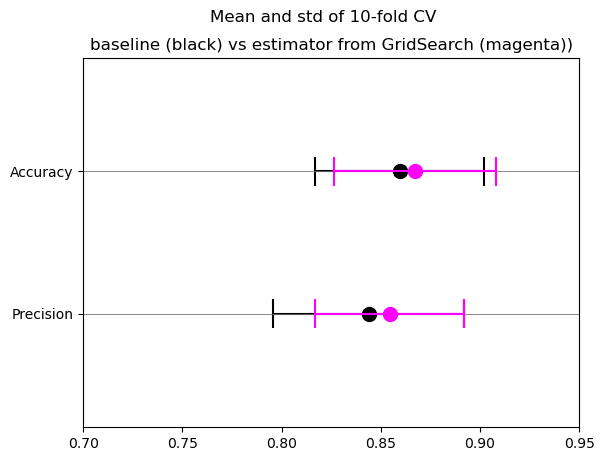

In [38]:
plot_cv_scores(rf_base_cv, rf_grid_cv)

## KNeighborsClassifier

#### Baseline

In [39]:
kn_base_cv = cross_validate(
    KNeighborsClassifier(), X_train_test, y_train_test, cv=10, scoring=scoring
)

#### GridSearch

In [40]:
param_grid = {
    "n_neighbors": [5, 10, 15],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
}

kn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    scoring=scoring,
    param_grid=param_grid,
    verbose=1,
    cv=10,
    refit="Accuracy",
    n_jobs=-1,
)

kn_grid.fit(X_train_test, y_train_test)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [5, 10, 15], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'Precision': make_scorer(precision_score, response_method='predict', pos_label=1)},
             verbose=1)

In [41]:
kn_grid_cv = cross_validate(
    kn_grid.best_estimator_, X_train_test, y_train_test, cv=10, scoring=scoring
)

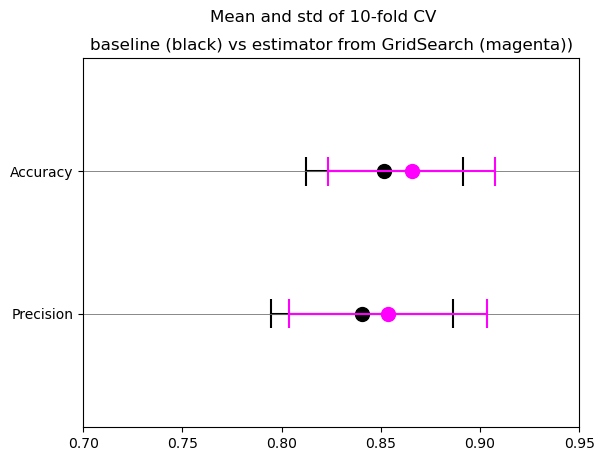

In [42]:
plot_cv_scores(kn_base_cv, kn_grid_cv)

## Adaboost
A ensemble method

#### Baseline

In [43]:
ada_base_cv = cross_validate(
    AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0),
    X_train_test,
    y_train_test,
    cv=10,
    scoring=scoring,
)

### Grid Search

#### Parameter descriptions

##### 1. **Number of Estimators (`n_estimators`)**:
   - **Description**: This is the number of weak learners (or base estimators) to be used in the boosting process. Higher values can lead to better performance but also increase the risk of overfitting.
   - **Typical Range**: `[50, 100, 200, 300, 400, 500]`

##### 2. **Learning Rate (`learning_rate`)**:
   - **Description**: This shrinks the contribution of each weak learner by multiplying their weights. A lower learning rate requires a higher number of estimators.
   - **Typical Range**: `[0.001, 0.01, 0.1, 0.5, 1.0]`

##### 3. **Base Estimator (`base_estimator`)**:
   - **Description**: The weak learner to be used. Typically, a decision tree classifier is used, but this can be replaced by other classifiers.
   - **Typical Range**:
     - For Decision Trees: `DecisionTreeClassifier(max_depth=1)` (default), or vary `max_depth`, `min_samples_split`, and `min_samples_leaf`.
     - Other weak learners: `DecisionTreeClassifier`, `SVM`, etc.

##### 4. **Algorithm (`algorithm`)**:
   - **Description**: The algorithm used to choose the weights for the weak learners.
   - **Options**: `['SAMME', 'SAMME.R']`
   - **Explanation**:
     - `SAMME.R` uses the probability estimates and generally performs better, especially when `base_estimator` can output class probabilities.
     - `SAMME` is a more traditional approach.

##### 5. **Random State (`random_state`)**:
   - **Description**: Controls the randomness of the bootstrapping of the samples used when building trees. It’s important for reproducibility.
   - **Typical Range**: `[None, 42, 1]` (using fixed seeds like `42` can help reproduce results)

##### 6. **Max Depth of Base Estimator (`max_depth`)**:
   - **Description**: Depth of the decision tree if it is used as the base estimator. Shallow trees prevent overfitting.
   - **Typical Range**: `[1, 2, 3, 4, 5]`

##### 7. **Min Samples Split (`min_samples_split`)** (if decision tree is used as the base estimator):
   - **Description**: The minimum number of samples required to split an internal node.
   - **Typical Range**: `[2, 5, 10]`

##### 8. **Min Samples Leaf (`min_samples_leaf`)** (if decision tree is used as the base estimator):
   - **Description**: The minimum number of samples required to be at a leaf node.
   - **Typical Range**: `[1, 2, 5, 10]`

In [44]:
"""
Check if all these methods always categorize the same, or different samples wrong. If the later is the case, this would motivate using a ensemble method to balance strengths and weaknesses of different classifiers.

Maybe building some ensemble method that combines a (gradient boosted) dewcicion tree for the categorical variables with something like SVM for the continuous data.

This would obviate the need for target encoding of A6 and A7 and poosible better handle the many binary variables in the dataset. 
"""

'\nCheck if all these methods always categorize the same, or different samples wrong. If the later is the case, this would motivate using a ensemble method to balance strengths and weaknesses of different classifiers.\n\nMaybe building some ensemble method that combines a (gradient boosted) dewcicion tree for the categorical variables with something like SVM for the continuous data.\n\nThis would obviate the need for target encoding of A6 and A7 and poosible better handle the many binary variables in the dataset. \n'

####

In [33]:
param_grid = {
    "algorithm": ["SAMME"],
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1.0],
}

# bigger version:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 1.0],
#     'algorithm': ['SAMME', 'SAMME.R'],
#     'base_estimator_max_depth': [1, 2, 3],
#     'base_estimator_min__samples_split': [2, 5],
#     'base_estimator_min__samples_leaf': [1, 2]
# }

ada_grid = GridSearchCV(
    AdaBoostClassifier(),
    param_grid,
    cv=10,
    scoring=scoring,
    refit="Accuracy",
    n_jobs=-1,
)
ada_grid.fit(X_train_test, y_train_test)

GridSearchCV(cv=10, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME'],
                         'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'Precision': make_scorer(precision_score, response_method='predict', pos_label=1)})

In [34]:
ada_grid_cv = cross_validate(
    ada_grid.best_estimator_, X_train_test, y_train_test, cv=10, scoring=scoring
)

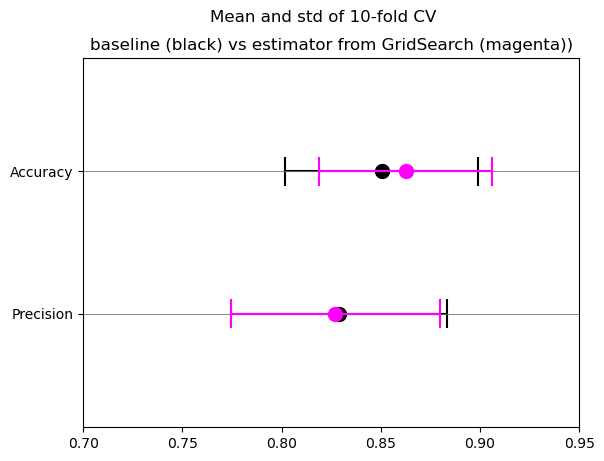

In [45]:
plot_cv_scores(ada_base_cv, ada_grid_cv)

# model comparison

## compare scores on validation set

In [ ]:
lda_grid
qda_grid
rf_grid
kn_grid
ada_grid

Text(0.5, 1.0, 'Precision')

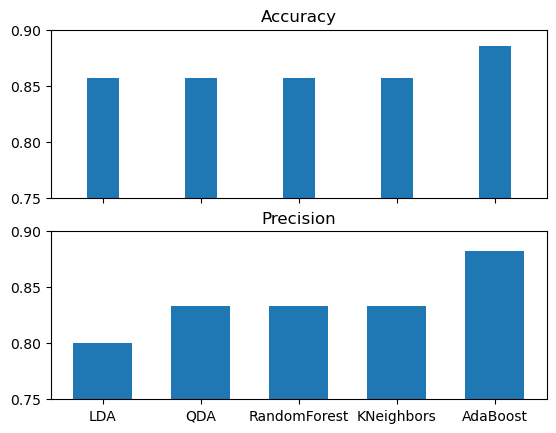

In [46]:
scores = pd.DataFrame(np.nan, index=("LDA","QDA","RandomForest", "KNeighbors","AdaBoost"), columns=("accuracy", "precision"))

for i, model in enumerate((lda_grid, qda_grid, rf_grid, kn_grid, ada_grid)):
    y_pred = model.best_estimator_.predict(X_validate)
    scores.iloc[i,0], scores.iloc[i,1] = accuracy_score(y_validate, y_pred), precision_score(y_validate, y_pred)

fig, axes = plt.subplots(2,1, sharex=True)

axes[0].bar(scores.index, scores.accuracy, width=.33)
axes[0].set_ylim(.75, .9)
axes[0].set_title("Accuracy")


axes[1].bar(scores.index, scores.precision, width=.6)
axes[1].set_ylim(.75, .9)
axes[1].set_title("Precision")


## ROC

Text(0.5, 1.0, 'ROC curve')

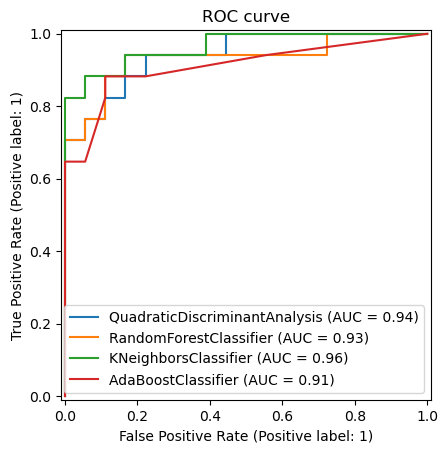

In [47]:
ax = plt.subplot()
#RocCurveDisplay.from_estimator(lda_grid.best_estimator_, X_validate, y_validate, ax=ax)
RocCurveDisplay.from_estimator(qda_grid.best_estimator_, X_validate, y_validate, ax=ax)
RocCurveDisplay.from_estimator(rf_grid.best_estimator_, X_validate, y_validate, ax=ax)
RocCurveDisplay.from_estimator(kn_grid.best_estimator_, X_validate, y_validate, ax=ax)
RocCurveDisplay.from_estimator(ada_grid.best_estimator_, X_validate, y_validate, ax=ax)
plt.title("ROC curve")

## Precision Recall Display

Text(0.5, 1.0, 'precision recall curve')

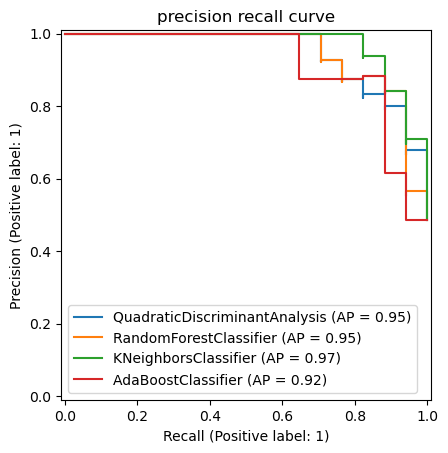

In [48]:
ax = plt.subplot()
#PrecisionRecallDisplay.from_estimator(lda_grid.best_estimator_, X_validate, y_validate, ax=ax)
PrecisionRecallDisplay.from_estimator(qda_grid.best_estimator_, X_validate, y_validate, ax=ax)
PrecisionRecallDisplay.from_estimator(rf_grid.best_estimator_, X_validate, y_validate, ax=ax)
PrecisionRecallDisplay.from_estimator(kn_grid.best_estimator_, X_validate, y_validate, ax=ax)
PrecisionRecallDisplay.from_estimator(ada_grid.best_estimator_, X_validate, y_validate, ax=ax)
plt.title("precision recall curve")

## DET curve

In [ ]:
"""AdaBoost has best accuracy/precision, KN has best ROC-AUC, QDA has second best ROC-AUC"""

ax = plt.subplot()
#DetCurveDisplay.from_estimator(lda_grid.best_estimator_, X_validate, y_validate, ax=ax)
DetCurveDisplay.from_estimator(qda_grid.best_estimator_, X_validate, y_validate, ax=ax)
#DetCurveDisplay.from_estimator(rf_grid.best_estimator_, X_validate, y_validate, ax=ax)
DetCurveDisplay.from_estimator(kn_grid.best_estimator_, X_validate, y_validate, ax=ax)
DetCurveDisplay.from_estimator(ada_grid.best_estimator_, X_validate, y_validate, ax=ax);
ax.legend()

###

In [ ]:
y_num = np.where(y_train == "+", 1, 0)
y_validate_num = np.where(y_validate == "+", 1, 0)

rf_num = search_rf.best_estimator_.fit(X_train, y_num)
knn_num = search_knn.best_estimator_.fit(X_train, y_num)

In [ ]:
# DetCurveDisplay.from_predictions(y_validate, rf_best.predict)
# Get prediction probabilities
rf_best = search_rf.best_estimator_
# probabilities = rf_best.predict_proba(X_validate)
# print("Prediction Probabilities:\n", probabilities)

In [ ]:
# Get class predictions (optional)
predictions_rf = rf_num.predict(X_validate)
print("Class Predictions:\n", predictions_rf)

predictions_knn = knn_num.predict(X_validate)
print("Class Predictions:\n", predictions_knn)

# DetCurveDisplay.from_predictions(y_validate_num, predictions_rf)
# DetCurveDisplay.from_predictions(y_validate_num, predictions_knn)

In [ ]:
# Model evauation

# Since classes are balanced, accuracy is the correct evaluation metric.

# Plot ROC for different hyperparameters

# above: plot full results of grid search to showcase effects of different hyperparameters